In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import sem
from sklearn import linear_model
%matplotlib inline

Welcome to the first in an iteration of Jupyter Notebooks analyzing various defensive stats in Out of the Park Baseball XX. For this series I created a new default MLB league in OOTP and chose to use the Seattle Mariners as the team to look at. Why the Seattle Mariners? Well, they are not a good baseball team in XX, and are expected to give up a lot of runs right out of the box, so any change in fielding ratings should be more evident on the Mariners, than say a team with good pitching that is not expected to give up a lot of runs in the first place.

Before diving into the rest of the setup for this, I want to stress that measuring the impact of fielding ratings on a team's performance is very fickle. Anything borne out in this analysis is going to be very weak in terms of predictive power. There are simply a lot of variables at play when trying to measure the impact of defense on runs allowed.

Setup:
I've already established I will be using the base MLB league in OOTPXX, and using the Seattle Mariners. Every rating that was used for this was modified from the default for that individual player. For this, I used the simulation module in game to simulate the season 100 times for each combination of ratings, scraping the HTML report after each simulation and saving that as a CSV file. I will primarily be looking at the number of runs allowed by the team in relation to the specific variable being tested, but in some instances when looking at catching data will expand to ERA/K/BB as well. 

For this experiment, I am using Domingo Santana as a proxy for Seth Beer. Santana is not a particualrly mobile outfielder, with a base range of 45 in game. This corresponds to where Seth Beer's outfield range was when he was starting to rack up Iron Glove awards. There is one difference between Beer and Santana and that is Beer always was in RF, while in this experiment Santana played only LF. In the below code block, I load the data from the experiment. Each row in the data corresponds to a different season, with the last column 'RLF' being the range rating on the 1-200 scale for that season.

In [2]:
santana = pd.read_csv('SantanaRange.csv')
santana.head()

,W,L,Runs,AVG,HR,SB,Runs against,ERA,K,BB,RLF
0,63,99,676,0.246,161,86,818,4.74,1307,521,75
1,71,91,642,0.237,152,106,800,4.58,1306,541,75
2,70,92,681,0.245,201,108,812,4.72,1312,517,75
3,59,103,618,0.244,154,89,897,5.24,1315,578,75
4,70,92,701,0.245,170,118,757,4.37,1292,525,75


Here are all the corresponding range ratings on the 20-80 scale that were used. The first should be 45, but is just a product of rounding that shows 40. Beer's outfield range decreased to 35 about two seasons ago now, which is the minimum in our test, while the maximum is a 75 range.

In [3]:
list(5 * np.round(((((santana.RLF.unique() - 1) * (80 - 20)) / (200 - 1)) + 20) / 5, 0))

[40.0, 35.0, 50.0, 55.0, 60.0, 70.0, 75.0]

A quick histogram looking at ranges of 45 and 35, and the number of seasons where the runs allowed fell into the respective buckets. It appears that the 45 range seasons had on average slightly fewer runs allowed, given the shift in the median and average to the left of the graph.

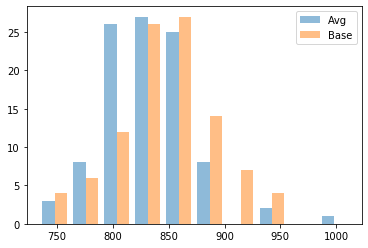

In [4]:
average = santana.loc[santana['RLF'] == 100, ['Runs against']]
base = santana.loc[santana['RLF'] == 75, ['Runs against']]

plt.hist([average['Runs against']
          , base['Runs against']
         ] , alpha=0.5, label=['Avg', 'Base', 'Super'])

plt.legend(loc='upper right')
plt.show()

A boxplot of all the various range ratings on the vertical axis, and the number of runs allowed on the horizonal axis. It's clear in the bottom three boxes that the median runs allowed decreases as the range rating increases. Once it gets to 125 (55) that drop-off seems to disappear. I am not really sure why that would be - perhaps at a certain point range in the COF spots does correlate to increased balls caught, or it could just be bad data. I could run the experiment again, but for now we'll roll with it.

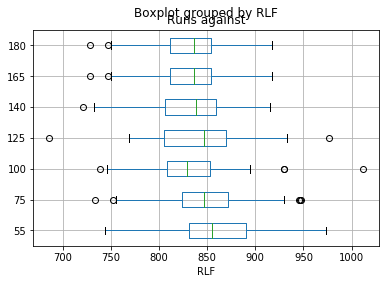

In [5]:
santana.boxplot('Runs against', by='RLF', vert=False)

I am not going to dive into model building, or cross-validation concepts for this series. We'll just build a model, and see what impact there is very quickly. These next two code blocks just build a model on the entire data set, and print out some diagnostic plots to veryify the models aren't biased in anyway.

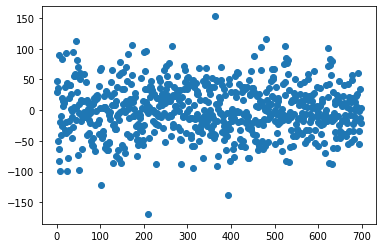

In [6]:
target = santana['Runs against']
variable = np.array(santana['RLF']).reshape(-1,1)
lr = linear_model.LinearRegression()
lr.fit(variable, target)
residuals = lr.predict(variable) - target
plt.scatter(residuals.index, residuals)
plt.show()

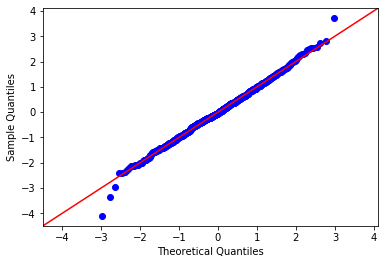

In [7]:
residuals = lr.predict(variable) - target
sm.qqplot(residuals, fit=True, line='45')
plt.show()

As said before, any relationship between any individual fielding rating and runs allowed is going to be very weak, as seen in the R2 score below, but that's fine.

In [8]:
lr.score(variable, target)

0.0295519864346897

For every five point change in outfield range, there appears to be a reduction in the number of runs allowed by about three over the course of a season based on this experiment. The difference between a 35 and 50 outfield range would be expcted to be about 9 runs over the course of a season.

In [9]:
lr.coef_

array([-0.16887008])

We can change the target variable from runs allowed to wins, since that's the ultimate objective in baseball. The difference between a 35 and a 50 outfield range in the data used above would be about a win over the course of a season.

In [10]:
target = santana['W']
lr.fit(variable, target)
lr.coef_[0] * 51

0.9165944881889777

But what happens if we get rid of the data for Outfield Range that was greater than 50 given? The number of runs allowed for a five point change in range jumps to about 9.8 runs per season, with the difference between a 35 and 50 range being about 30 runs. 

In [11]:
santana2 = pd.read_csv('SantanaRange2.csv')
target = santana2['Runs against']
variable = np.array(santana2['RLF']).reshape(-1,1)
lr.fit(variable, target)
lr.coef_

array([-0.55536066])

Below is a boxplot looking at just these three ranges. The median green line in each box clearly shifts to the left as the range increases, as well as the range of the tails on either end.

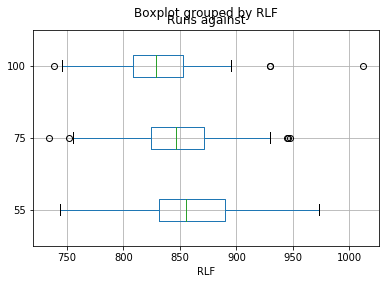

In [12]:
santana2.boxplot('Runs against', by='RLF', vert=False)

Just as we did for the full dataset, we can look at wins for the pared down data. We'd expect about a 2.7 win difference between an OF range of 35 and 50.

In [13]:
target = santana2['W']
lr.fit(variable, target)
lr.coef_[0] * 51

2.755672131147539

Do I think there is a nearly 10 run difference for every five point change in outfield range? Probably not, but I think it's an interesting thought that might have to be re-visited with more experimentation. It could be a non-linear relationship between outfield range in the corner, and runs allowed, where there are diminishing returns for increases in range.